## Báo cáo Xử lý đa chiều
## Code demo: Auto encoder RICA

### Nhóm:
#### 1. Nguyễn Minh Hoàng - 18110095
#### 2. Nguyễn Phú Thành - 18110014
#### 3. Vương Ngọc Hương Thảo - 18110223

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

In [ ]:
seed = 0
torch.manual_seed(seed)
rnd = np.random.RandomState(seed)

In [ ]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(
    root = "~/torch_datasets", train = True, transform = transform, download = True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = 1, shuffle = True
)

In [ ]:
class RICA(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.input_shape, self.encoder_shape = kwargs['input_shape'], kwargs['encoder_shape']
        self.W = torch.autograd.Variable(torch.randn(self.encoder_shape, self.input_shape), requires_grad = True)
    
    def forward(self, X_train):
        encoder = torch.mm(self.W, X_train)
        reconstruct = torch.mm(torch.t(self.W), encoder)
        return reconstruct

In [ ]:
# Lây 1 data sample từ tập train
for batch_sample, _ in train_loader:
    train_sample = batch_sample.view(-1, 784).numpy().reshape((28, 28))
    break

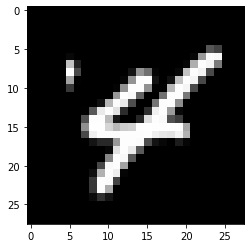

In [ ]:
plt.imshow(train_sample, cmap = plt.cm.gray)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RICA(input_shape = 28, encoder_shape = 18).to(device)
X = train_sample.T.copy()

In [ ]:
epochs = 10000
learning_rate = 1e-3
regularization = 0.1

In [ ]:
epsilon = 0.01
for epoch in range(epochs):
    # Shuffle data tại mỗi epoch
    rnd.shuffle(X)
    for i in range(X.shape[0]):
        batch_features = torch.from_numpy(X[i, :].reshape(28, 1))
        outputs = model(batch_features)
        reconstruction_loss = (outputs - batch_features).pow(2).sum()
        regularization_loss = regularization * torch.sqrt(torch.mm(model.W, batch_features).pow(2).sum() + epsilon)

        train_loss = 1/2 * reconstruction_loss + regularization_loss

        train_loss.backward()
        
        model.W.data -= learning_rate * model.W.grad.data
        model.W.grad.data.zero_()

In [ ]:
reconstruct = []
X = train_sample.T.copy()
for i in range(28):
    temp = torch.from_numpy(X[i, :].reshape(28, 1))
    col = model(temp)
    reconstruct.append(col.detach().numpy())
reconstruct = np.hstack(reconstruct)

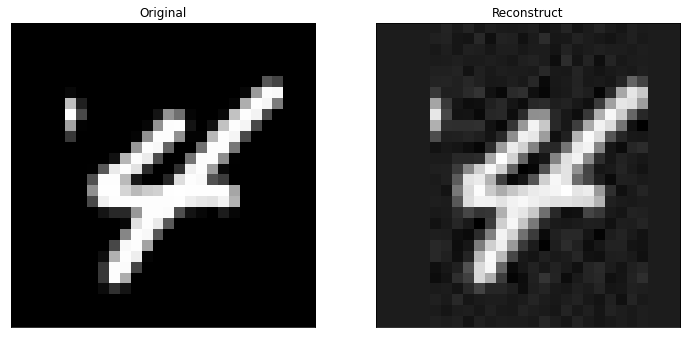

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 10))

axes[0].imshow(train_sample, cmap = plt.cm.gray)
axes[1].imshow(reconstruct, cmap = plt.cm.gray)

for i, name in enumerate(('Original', 'Reconstruct')):
    axes[i].set(title = f'{name}', xticks = [], yticks = [])
fig.savefig('Demo-RICA.jpg')